В библиотеке transformers примерно 2 года назад был PR, который сделал убрал обратную совместимость с предыдущими версиями (<4.12). Из-за чего перестали работать предобученные ранее модели. Чтобы это исправить, пришлось восстановить код модели EncoderDecoder и найти Trainer из предыдущих версий
https://github.com/huggingface/transformers/pull/14139/files

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from pathlib import Path

cache_path = Path("C:\\tempjeka\\cache")

<IPython.core.display.Javascript object>

In [3]:
import os

os.environ["TORCH_HOME"] = str(cache_path / "models")
os.environ["HF_HOME"] = str(cache_path / "huggingface")
os.environ["HUGGINGFACE_HUB_CACHE"] = str(cache_path / "huggingface")
os.environ["TRANSFORMERS_CACHE"] = str(cache_path / "huggingface")
os.environ["HF_DATASETS_CACHE"] = str(cache_path / "huggingface")

<IPython.core.display.Javascript object>

In [4]:
import pytorch_lightning as pl
import wget
from datasets import Dataset, load_dataset, DatasetDict, load_metric
import torch.utils.data as td
from transformers import (
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    AutoModelForSeq2SeqLM,
    EncoderDecoderModel,
    BertTokenizerFast,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)
import torch
from torchinfo import summary
import torch.nn as nn
from copy import deepcopy
import evaluate
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F

<IPython.core.display.Javascript object>

In [5]:
# wget.download(
#     "https://raw.githubusercontent.com/huggingface/transformers/main/examples/legacy/seq2seq/seq2seq_trainer.py"
# )
# wget.download(
#     "https://raw.githubusercontent.com/huggingface/transformers/main/examples/legacy/seq2seq/seq2seq_training_args.py"
# )

<IPython.core.display.Javascript object>

In [6]:
batch_size = 4
source_lang = "en"
target_lang = "ru"
max_input_length = 128
max_target_length = 128
prefix = ""

<IPython.core.display.Javascript object>

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda"

<IPython.core.display.Javascript object>

In [8]:
data_folder = Path("data")
en_ru_data_path = data_folder / "en-ru.txt"
if not en_ru_data_path.exists():
    data_folder.mkdir(exist_ok=True)
    wget.download(
        "https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt",
        out=str(en_ru_data_path),
    )

<IPython.core.display.Javascript object>

In [9]:
def dataset_convert_csv():
    with open(en_ru_data_path, encoding="utf8") as f:
        lines = f.readlines()
    for line in lines:
        en, ru = line.split("\t")
        yield dict(translation=dict(en=en, ru=ru))

<IPython.core.display.Javascript object>

In [10]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-cased")
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token

test = Dataset.from_generator(
    dataset_convert_csv, cache_dir=os.environ["HF_DATASETS_CACHE"]
).train_test_split(0.1, seed=0)
val = test["test"].train_test_split(0.99, seed=0)

Found cached dataset generator (C:/tempjeka/cache/huggingface/generator/default-0d1afdb327d32ae1/0.0.0)
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-0d1afdb327d32ae1\0.0.0\cache-79b8f716cada2ec2.arrow and C:\tempjeka\cache\huggingface\generator\default-0d1afdb327d32ae1\0.0.0\cache-41909bb8188e82c6.arrow
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-0d1afdb327d32ae1\0.0.0\cache-3d33209f1b428dce.arrow and C:\tempjeka\cache\huggingface\generator\default-0d1afdb327d32ae1\0.0.0\cache-a05f216f3463ced0.arrow


<IPython.core.display.Javascript object>

In [11]:
def preprocess_function(batch):
    inputs = tokenizer(
        [prefix + ex[source_lang] for ex in batch["translation"]],
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
    )
    outputs = tokenizer(
        [ex[target_lang] for ex in batch["translation"]],
        max_length=max_target_length,
        truncation=True,
        padding="max_length",
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["decoder_input_ids"] = outputs.input_ids
    batch["decoder_attention_mask"] = outputs.attention_mask
    batch["labels"] = outputs.input_ids.copy()

    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch

<IPython.core.display.Javascript object>

In [12]:
dataset = DatasetDict(
    dict(train=test["train"], val=val["train"], test=val["test"])
).map(preprocess_function, batched=True, batch_size=batch_size)
dataset.set_format(
    type="torch",
    columns=[
        "input_ids",
        "attention_mask",
        "decoder_input_ids",
        "decoder_attention_mask",
        "labels",
    ],
)

Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

In [13]:
dataset, dataset["train"][0]

(DatasetDict({
     train: Dataset({
         features: ['translation', 'input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels'],
         num_rows: 45000
     })
     val: Dataset({
         features: ['translation', 'input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels'],
         num_rows: 50
     })
     test: Dataset({
         features: ['translation', 'input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels'],
         num_rows: 4950
     })
 }),
 {'input_ids': tensor([  101, 23223, 10464, 10124, 12566, 24713, 10336, 10111, 10393,   169,
          10813, 10169, 31227, 10111, 16868,   118, 10178,   118, 17904, 48101,
            119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,

<IPython.core.display.Javascript object>

In [14]:
from transformers import EncoderDecoderModel
from transformers.modeling_outputs import Seq2SeqLMOutput


class TranslationModel(EncoderDecoderModel):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs,
    ):
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )
        kwargs_encoder = {
            argument: value
            for argument, value in kwargs.items()
            if not argument.startswith("decoder_")
        }
        kwargs_decoder = {
            argument[len("decoder_") :]: value
            for argument, value in kwargs.items()
            if argument.startswith("decoder_")
        }
        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                inputs_embeds=inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
                **kwargs_encoder,
            )

        encoder_hidden_states = encoder_outputs[0]
        # Decode
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=attention_mask,
            inputs_embeds=decoder_inputs_embeds,
            labels=labels,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            use_cache=use_cache,
            past_key_values=past_key_values,
            return_dict=return_dict,
            **kwargs_decoder,
        )
        if not return_dict:
            return decoder_outputs + encoder_outputs

        return Seq2SeqLMOutput(
            loss=decoder_outputs.loss,
            logits=decoder_outputs.logits,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )


bert2bert = TranslationModel.from_encoder_decoder_pretrained(
    "bert-base-multilingual-cased", "bert-base-multilingual-cased"
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bia

<IPython.core.display.Javascript object>

In [15]:
bert2bert

TranslationModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

<IPython.core.display.Javascript object>

In [16]:
# bert2bert = EncoderDecoderModel.from_pretrained("bert2bert")

<IPython.core.display.Javascript object>

In [17]:
bert2bert.config.decoder_start_token_id = tokenizer.bos_token_id
bert2bert.config.eos_token_id = tokenizer.eos_token_id
bert2bert.config.pad_token_id = tokenizer.pad_token_id
bert2bert.config.vocab_size = bert2bert.config.decoder.vocab_size

bert2bert.config.max_length = 142
bert2bert.config.min_length = 10
bert2bert.config.no_repeat_ngram_size = 3
bert2bert.config.early_stopping = True
bert2bert.config.length_penalty = 2.0
bert2bert.config.num_beams = 4
bert2bert.config

EncoderDecoderConfig {
  "_commit_hash": null,
  "decoder": {
    "_name_or_path": "bert-base-multilingual-cased",
    "add_cross_attention": true,
    "architectures": [
      "BertForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "directionality": "bidi",
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "initializer_range": 0.02,
    "intermediate_size": 3

<IPython.core.display.Javascript object>

In [18]:
version = 11

<IPython.core.display.Javascript object>

In [19]:
from seq2seq_trainer import Seq2SeqTrainer
from seq2seq_training_args import Seq2SeqTrainingArguments

<IPython.core.display.Javascript object>

In [20]:
version += 1
args = Seq2SeqTrainingArguments(
    output_dir=f"bert",
    evaluation_strategy="steps",
    learning_rate=5e-5,
    lr_scheduler_type="cosine_with_restarts",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=1,
    num_train_epochs=2,
    predict_with_generate=True,
    warmup_steps=1000,
    fp16=True,
    logging_dir=f"../made/logs/lightning_logs/bert/{version}",
    logging_first_step=False,
    eval_steps=1000,
    overwrite_output_dir=True,
)

<IPython.core.display.Javascript object>

In [21]:
import numpy as np

metric = evaluate.load("bleu")


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["bleu"]}
    return result

<IPython.core.display.Javascript object>

In [22]:
trainer = Seq2SeqTrainer(
    model=bert2bert,
    tokenizer=tokenizer,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
)

<IPython.core.display.Javascript object>

In [23]:
trainer.train()

C:\tempjeka\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Bleu
1000,2.705300,2.236222,0.054865
2000,2.148100,1.815855,0.104811
3000,1.925000,1.672873,0.140287
4000,1.773800,1.508566,0.173803
5000,1.638100,1.411600,0.194761
6000,1.545700,1.247658,0.212856
7000,1.412900,1.193926,0.219990
8000,1.374200,1.089549,0.264489
9000,1.275300,0.991497,0.273491
10000,1.203900,0.910925,0.269279


C:\tempjeka\anaconda3\lib\site-packages\transformers\generation\utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
bert2bert.save_pretrained("bert2bert")

<IPython.core.display.Javascript object>

In [25]:
model = bert2bert

<IPython.core.display.Javascript object>

In [26]:
metric = evaluate.load("bleu")


def compute_metrics(batch):
    preds = model.generate(
        batch["input_ids"].to(device),
        attention_mask=batch["attention_mask"].to(device),
    ).cpu()
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(batch["labels"] != -100, batch["labels"], tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    metric.add_batch(references=decoded_labels, predictions=decoded_preds)


model.eval()
with torch.no_grad():
    dataset["test"].map(compute_metrics, batched=True, batch_size=batch_size)

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

C:\tempjeka\anaconda3\lib\site-packages\transformers\generation\utils.py:1313: UserWarning: Using `max_length`'s default (142) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


<IPython.core.display.Javascript object>

In [27]:
metric.compute()

{'bleu': 0.3311506096736599,
 'precisions': [0.6028060376354811,
  0.3983628728023347,
  0.2951527682058351,
  0.22073079791200598],
 'brevity_penalty': 0.9363409088336769,
 'length_ratio': 0.9382837748468325,
 'translation_length': 75195,
 'reference_length': 80141}

<IPython.core.display.Javascript object>

In [28]:
batch = dataset["test"][:batch_size]
model.eval()
with torch.no_grad():
    preds = model.generate(
        batch["input_ids"].to(device),
        attention_mask=batch["attention_mask"].to(device),
    ).cpu()
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(batch["labels"] != -100, batch["labels"], tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

list(zip(decoded_preds, decoded_labels))

[('В ресторане отеля подают разнообразные блюда интернациональной кухни, а в баре на берегу моря можно отведать панорамный вид на море.',
  ['В ресторане отеля подают разнообразные блюда интернациональной кухни в формате " шведский стол ". Блюда можно отведать у бассейна с панорамным видом на море.']),
 ('К услугам гостей бесплатный Wi - Fi и парковка.',
  ['WiFi и парковка предоставляются бесплатно.']),
 ('К услугам гостей бесплатный Wi - Fi во всех зонах, а на территории отеля обустроена частная парковка.',
  ['К услугам гостей бесплатный Wi - Fi во всех зонах и бесплатная частная парковка на территории.']),
 ('В собственной ванной комнате с душем предоставляются бесплатные туалетно - косметические принадлежности.',
  ['В собственной ванной комнате с душем предоставляются бесплатные туалетно - косметические принадлежности.'])]

<IPython.core.display.Javascript object>

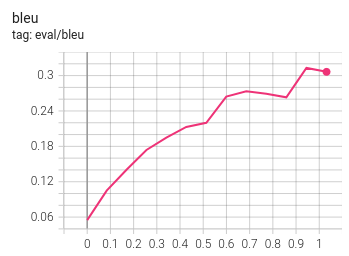 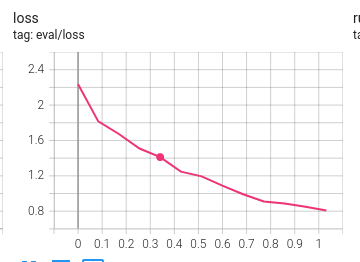 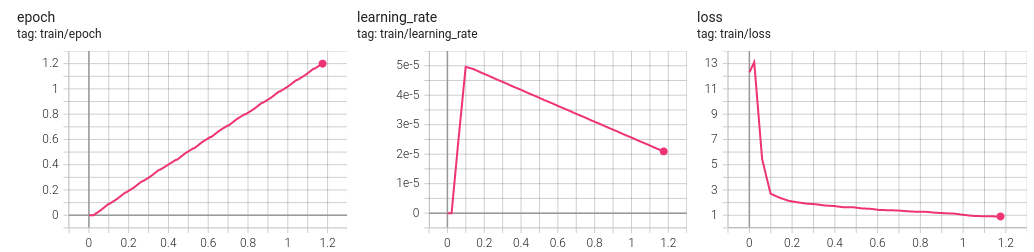